### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [128]:
import torch as t
import matplotlib.pyplot as plt

import einops
from days.w3d2.w3d2_tests import get_minigpt, MiniGPT, tokenizer

from days.w3d5 import gpt_mod
from days.w3d5.hook_handler import HookHandler
from torch import nn

from transformers.models.gpt2.modeling_gpt2 import GPT2LMHeadModel
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast


### Load model

In [7]:
mgpt = get_minigpt("../w3d2/model.pt")
mgpt

MiniGPT(
  (token_embedding): Embedding(50259, 256)
  (pos_embedding): Embedding(512, 256)
  (blocks): Sequential(
    (0): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
    (1): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
  )
)

In [50]:
text1 = "[BEGIN] So far, we've developed a theoretical model for understanding two-layer attention-only models. We have an overall equation describing the logits (the OV circuit), and then an equation describing how each attention head's attention pattern is computed (the QK circuit). But how do we understand them in practice? In this section, we'll reverse engineer a single two-layer model."
input_ids = tokenizer(text1, return_tensors="pt").input_ids
print(input_ids.shape)

alc = mgpt.all_logit_contributions(input_ids)
alc.shape


torch.Size([1, 79])


torch.Size([9, 9, 1, 79, 50259])

Predicting the next token after the following prefix (should be ' how')
[BEGIN] So far, we've developed a theoretical model for understanding two-layer attention-only models. We have an overall equation describing the logits (the OV circuit), and then an equation describing
torch.Size([9, 9, 10])


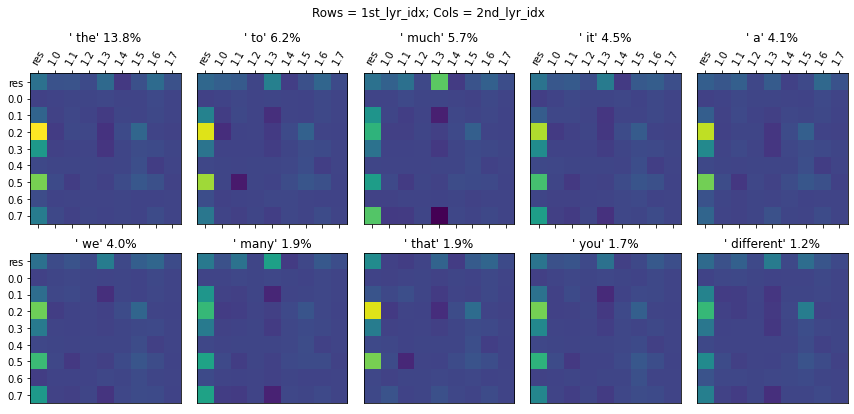

In [70]:
def show_pred_logit_paths(model, text, target_idx, k=10):
    input_ids = tokenizer(text, return_tensors="pt").input_ids

    alc = model.all_logit_contributions(input_ids).detach()
    target_id = input_ids[0, target_idx].item()
    target_word = tokenizer.decode(target_id)
    prefix = tokenizer.decode(input_ids[0, :target_idx])

    print(f"Predicting the next token after the following prefix (should be {repr(target_word)})")
    print(prefix)

    logits = einops.reduce(alc, "... 1 seq_len vocab_size -> seq_len vocab_size", reduction="sum")

    target_logits = logits[target_idx]
    target_probs = t.softmax(target_logits, dim=0)
    top_pred_ids = t.topk(target_logits, k=k).indices

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle("Rows = 1st_lyr_idx; Cols = 2nd_lyr_idx")

    alc_norm = alc - alc.mean(dim=-1, keepdim=True)

    matrices = alc_norm[:, :, 0, target_idx, top_pred_ids]
    print(matrices.shape)
    vmin, vmax = matrices.min(), matrices.max()

    for i, pred_id in enumerate(top_pred_ids):
        ax = plt.subplot(2, k // 2, i + 1)

        # rows: first layer index
        # cols: second layer index
        ax.matshow(matrices[:, :, i], vmin=vmin, vmax=vmax);
        ax.set_title(f"{repr(tokenizer.decode(pred_id))} {target_probs[pred_id]:.1%}")

        row_len = k // 2
        row = i // row_len
        col = i % row_len
        if col == 0:
            ax.set_yticks(range(9))
            ax.set_yticklabels(["res"] + [f"0.{h}" for h in range(8)])
        else:
            ax.set_yticks([])
        
        if row == 0:
            ax.set_xticks(range(9))
            ax.set_xticklabels(["res"] + [f"1.{h}" for h in range(8)], rotation=60)
        else:
            ax.set_xticks([])
    
    plt.tight_layout()

show_pred_logit_paths(mgpt, text1, 40)


Predicting the next token after the following prefix (should be 'layer')
[BEGIN] So far, we've developed a theoretical model for understanding two-layer attention-only models. We have an overall equation describing the logits (the OV circuit), and then an equation describing how each attention head's attention pattern is computed (the QK circuit). But how do we understand them in practice? In this section, we'll reverse engineer a single two-
tensor([[-5.3075e-01,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan],
        [-1.1701e-03, -1.7325e-01,  8.3924e-02, -2.5813e-01, -4.9117e-01,
         -1.7945e-01,  1.6225e-01, -2.4219e-01],
        [-3.3441e-02,  1.1476e-01,  2.8544e-01,  1.9236e-01,  1.5320e+00,
         -2.1430e-01,  1.7800e+00,  8.2053e-02]])


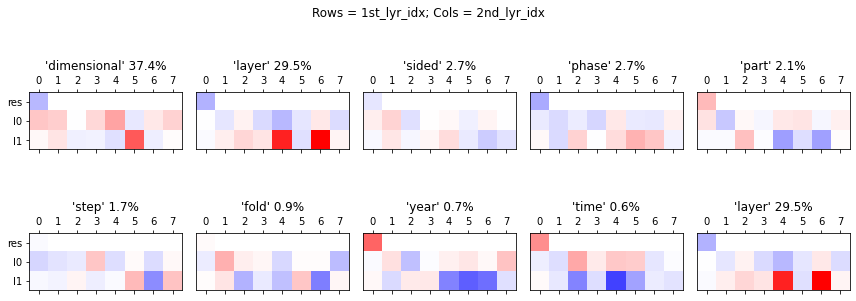

In [103]:
def show_pred_logit_paths_v2(model, text, target_idx, k=10):
    input_ids = tokenizer(text, return_tensors="pt").input_ids
    target_id = input_ids[0, target_idx].item()
    target_word = tokenizer.decode(target_id)
    prefix = tokenizer.decode(input_ids[0, :target_idx])

    print(
        f"Predicting the next token after the following prefix (should be {repr(target_word)})"
    )
    print(prefix)

    all_contrib = model.all_logit_contributions(input_ids).detach()
    target_contrib = all_contrib[:, :, 0, target_idx - 1]
    assert len(target_contrib.shape) == len(("lyr1", "lyr2", "vocab_size"))

    res_contrib = target_contrib[0, 0]
    l1_contrib = target_contrib[1:, 0]
    l2_contrib = target_contrib[:, 1:].sum(dim=0)

    target_logits = einops.reduce(
        target_contrib, "... vocab_size -> vocab_size", reduction="sum"
    )
    target_probs = t.softmax(target_logits, dim=0)
    top_pred_ids = t.topk(target_logits, k=k).indices
    top_pred_ids[-1] = target_id

    num_heads = l1_contrib.shape[0]
    mats_to_show = t.full((3, num_heads, k), fill_value=t.nan)
    mats_to_show[0, 0] = res_contrib[top_pred_ids]
    mats_to_show[1] = l1_contrib[:, top_pred_ids]
    mats_to_show[2] = l2_contrib[:, top_pred_ids]
    mats_to_show -= mats_to_show.mean(dim=-1, keepdim=True)
    print(mats_to_show[:, :, -1])

    vabsmax = mats_to_show[~t.isnan(mats_to_show)].abs().max()
    # vmin = mats_to_show[~t.isnan(mats_to_show)].min()
    # vmax = mats_to_show[~t.isnan(mats_to_show)].max()

    fig.suptitle("Rows = 1st_lyr_idx; Cols = 2nd_lyr_idx")
    for i, pred_id in enumerate(top_pred_ids):
        ax = plt.subplot(2, k // 2, i + 1)

        # rows: first layer index
        # cols: second layer index
        cmap = plt.cm.get_cmap("bwr").copy()
        cmap.set_bad(color='white')
        ax.matshow(mats_to_show[:, :, i], vmin=-vabsmax, vmax=vabsmax, cmap=cmap)
        ax.set_title(f"{repr(tokenizer.decode(pred_id))} {target_probs[pred_id]:.1%}")

        row_len = k // 2
        row = i // row_len
        col = i % row_len
        if col == 0:
            ax.set_yticks(range(3))
            ax.set_yticklabels(["res", "l0", "l1"])
        else:
            ax.set_yticks([])

        # if row == 0:
        #     ax.set_xticks(range(9))
        #     ax.set_xticklabels(["res"] + [f"1.{h}" for h in range(8)], rotation=60)
        # else:
        #     ax.set_xticks([])

    plt.tight_layout()

fig = plt.figure(figsize=(12, 5))
show_pred_logit_paths_v2(mgpt, text1, 76)


### GPT2

In [127]:
gpt2 = gpt_mod.load_weights(gpt_mod.GPT2)
gpt_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

In [137]:
res_embedding = None
head_embeddings = []


def he_hook(
    block: gpt_mod.GPT2Block,
    inputs: tuple[t.Tensor],
    outputs: t.Tensor,
):
    _, out_headwise = block.forward(inputs[0], return_headwise=True)
    head_embeddings.append(out_headwise)


with HookHandler() as hh:
    def foo(_, inputs, __):
        global res_embedding
        res_embedding = inputs[0]
    hh.add_hook(gpt2.blocks[0], foo)

    for block in gpt2.blocks:
        hh.add_hook(block, he_hook)

    input_ids = gpt_tokenizer.encode(text1, return_tensors="pt")
    gpt2(input_ids)

    print(res_embedding.shape)
    print(len(head_embeddings))
    print(head_embeddings[0].shape)


torch.Size([1, 82, 768])
12
torch.Size([1, 14, 82, 768])
All hooks removed!


In [133]:
out = gpt2(gpt_tokenizer.encode(text1, return_tensors='pt'), output_hidden_states=True)
len(out.hidden_states), out.hidden_states[0].shape

TypeError: forward() got an unexpected keyword argument 'output_hidden_states'

In [117]:
gpt2.transformer.ln_f.weight

Parameter containing:
tensor([1.3971e+00, 1.3750e+00, 1.8870e+00, 1.1688e+00, 1.2724e+00, 1.2508e+00,
        9.4198e+00, 1.4371e+00, 1.4527e+00, 1.1856e+00, 1.3945e+00, 1.2796e+00,
        1.2071e+00, 1.2951e+00, 1.2776e+00, 1.3480e+00, 1.5088e+00, 1.3729e+00,
        1.3427e+00, 2.3761e+00, 1.1377e+00, 1.2909e+00, 1.3477e+00, 1.4775e+00,
        1.2540e+00, 1.1999e+00, 1.4932e+00, 1.1637e+00, 1.2590e+00, 1.2305e+00,
        1.1833e+00, 1.1914e+00, 1.2228e+00, 1.2792e+00, 1.3294e+00, 1.6213e+00,
        1.3804e+01, 1.1871e+00, 1.2235e+00, 1.4578e+00, 1.1687e+00, 1.3164e+00,
        1.1444e+00, 1.2628e+00, 1.4781e+00, 1.2426e+00, 1.1744e+00, 1.1602e+00,
        1.3637e+00, 2.1280e+00, 1.2371e+00, 1.2336e+00, 1.7410e+00, 1.1568e+00,
        1.3303e+00, 1.8593e+00, 1.2932e+00, 1.3320e+00, 1.2148e+00, 1.5415e+00,
        1.3781e+00, 1.2070e+00, 1.4030e+00, 1.5724e+00, 7.6159e-03, 1.1836e+00,
        1.2148e+00, 1.2604e+00, 1.8500e+00, 1.1540e+00, 1.2933e+00, 1.1572e+00,
        1.2341e+00